In [1]:
import os
import pandas
import numpy
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.ticker as ticker
import warnings

# Ignore numpy VisibleDeprecationWarning
warnings.filterwarnings('ignore', category=numpy.VisibleDeprecationWarning)

# Data analysis
box plots: https://matplotlib.org/stable/gallery/statistics/boxplot_demo.html
TODO:
- 3.4a: box plot of total time of videos
- 3.4b: number of videos per step
- 3.4c: box plot of total time per step (across all videos)
- 3.3b: matrix of step transitions


1. Create dataframe
2. Add a step number column (map via a dictionary)
3. Retrieve max time stamp per video and do a box plot (figure 3.4a). Compare with rs_closure cutoff step
4. Retrieve number, steps and remove duplicates. Then do group by number, steps and count total. Plot frequency plot 3.4b (number of videos per step)
5. Add extra column of total time of step i.e next timestamp minus current timestamp. Group by steps, video number the total time taken. Box plot 3.4c
6. 3.3b: Add next step column (if idle and following step is the same, then go to next step still to get the step being transitioned to). Group by current_step, next_step and count. Create a matrix plot.


In [2]:
path = r'/Users/dorotheeduvaux 1/UCL CSML/MSc Project'
filename = 'data_steps.csv'
dataset_df = pandas.read_csv(os.path.join(path, filename))

In [3]:
PATH_FOR_SAVING = r'/Users/dorotheeduvaux 1/UCL CSML/MSc Project/Video analytics'
TOTAL_NUMBER_OF_STEPS=5

In [4]:
dataset_df

,approach,number,step,timestamp
0,RS,1,rs_approach_and_exposure,00:00:04
1,RS,1,rs_tumour_debunking_and_excision,00:02:38
2,RS,1,tumour_debulking,00:03:09
3,RS,1,idle_time,00:04:44
4,RS,1,tumour_debulking,00:05:44
...,...,...,...,...
2657,RS,9,idle_time,05:12:51
2658,RS,9,tumour_debulking,05:16:13
2659,RS,9,rs_closure,05:16:18
2660,RS,9,idle_time,05:27:57


In [5]:
def modify_idle_string(value):
    if 'idle' in value.lower():
        new_value = 'idle_time'
    else:
        new_value = value
    return new_value

In [6]:
output_data = dataset_df.groupby(['step']).count().reset_index()
output_data.to_csv(os.path.join(PATH_FOR_SAVING, 'raw_steps.csv'))

In [7]:
# Removing these steps because these are often taken as notes at exactly the same timestamp as an actual step. 
# So this is redundant information, which might make it look like a step takes 0 seconds, when it doesn't
other_steps = [
    'This is a cystic tumour - with the cystic possibly already opened at the start of video',
    'Started drilling',
    'Cystic component opened',
    'Solid component opened'
]
dataset_df = dataset_df[~dataset_df['step'].isin(other_steps)].copy()
dataset_df['step'] = dataset_df['step'].apply(modify_idle_string)
dataset_df['step'].drop_duplicates()

0               rs_approach_and_exposure
1       rs_tumour_debunking_and_excision
2                       tumour_debulking
3                              idle_time
5                      dissection_medial
7                    dissection_inferior
8                    dissection_superior
146                           rs_closure
189                   dissection_lateral
200         Video finished from 02:30:00
1238           Cannot see surgical field
1798        Video Finished from 03:03:37
2179          Video finished at 06:49:07
2340          Video finished at 06:38:55
2661          Video finished at 05:27:57
Name: step, dtype: object

In [8]:
step_map = {
    'tumour_debulking':1,
    'dissection_medial':2,
    'dissection_inferior':3,
    'dissection_superior':4,
    'dissection_lateral':5,
    'idle_time':'p0',
    'rs_approach_and_exposure':'p1',
    'rs_tumour_debunking_and_excision': 'p2',
    'rs_closure': 'p3',
}
dataset_df['current_step_number'] = dataset_df['step'].map(step_map) 
dataset_df['current_step_number'] = dataset_df['current_step_number'].fillna('other')

In [9]:
dataset_df[dataset_df['current_step_number'] == 'other']

,approach,number,step,timestamp,current_step_number
200,RS,11,Video finished from 02:30:00,02:30:00,other
1238,RS,24,Cannot see surgical field,02:31:27,other
1251,RS,24,Cannot see surgical field,03:14:40,other
1525,RS,25,Cannot see surgical field,03:30:31,other
1772,RS,27,Cannot see surgical field,02:29:09,other
1798,RS,27,Video Finished from 03:03:37,03:03:38,other
2179,RS,6,Video finished at 06:49:07,06:49:08,other
2340,RS,7,Video finished at 06:38:55,06:39:17,other
2661,RS,9,Video finished at 05:27:57,05:28:03,other


### Plotting function

In [10]:
def plotting_function(data, y_label, plot_name, x_label, steps_in_data=True, formatter=None, ymin=None, ymax=None, 
                      title=None):
    if isinstance(data, dict):
        values = data.values()
        keys = data.keys()
    else:
        values = data
        keys = ['']
    fig, ax1 = plt.subplots()
    ax1.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax1.set_ylabel(y_label)
    if x_label is not None:
        ax1.set_xlabel(x_label)
    if ymin is not None and ymax is not None:
        ax1.set_ylim(ymin, ymax) #data.max() * 1.5
    ax1.set_xticklabels(keys)
    if formatter is not None:
        ax1.yaxis.set_major_formatter(formatter)
    if title is not None:
        ax1.set_title(title)


    flierprops = dict(marker='o', markerfacecolor='tab:blue', markersize=4, markeredgewidth=0.5)
    boxprops = dict(linewidth=0.5, color='black')
    whiskerprops = dict(linewidth=0.5, color='black')
    medianprops = dict(linewidth=0.5, color='black')
    capprops = dict(linewidth=0.5, color='black')


    bp = ax1.boxplot(values, notch=False, sym='o', vert=True, whis=1.5, 
                     flierprops=flierprops,
                     boxprops=boxprops,
                     whiskerprops=whiskerprops,
                     medianprops=medianprops,
                     capprops=capprops,
                    )
    
    if steps_in_data:
        for step in range(TOTAL_NUMBER_OF_STEPS):
            box_coords = numpy.column_stack([bp['boxes'][step].get_xdata(), bp['boxes'][step].get_ydata()])
            ax1.add_patch(Polygon(box_coords, facecolor='tab:blue'))
            ax1.plot(numpy.average(bp['medians'][step].get_xdata()), numpy.average(data[str(step+1)]),
                         color='black', marker='x', markersize=6)
    else:
        box_coords = numpy.column_stack([bp['boxes'][0].get_xdata(), bp['boxes'][0].get_ydata()])
        ax1.add_patch(Polygon(box_coords, facecolor='tab:blue'))
        ax1.plot(numpy.average(bp['medians'][0].get_xdata()), numpy.average(data),
                     color='black', marker='x', markersize=6)

        
    fig.savefig(os.path.join(PATH_FOR_SAVING, f'{plot_name}.png'), bbox_inches='tight')


### Max timestamp per video

In [18]:
dataset_df['new_timestamp'] = pandas.to_datetime(dataset_df['timestamp'], format='%H:%M:%S') #.dt.time
earliest_timestamp = pandas.to_datetime('00:00:00', format='%H:%M:%S')
dataset_df['hours'] = (dataset_df['new_timestamp'] - earliest_timestamp)/ pandas.Timedelta(hours=1)
dataset_df['minutes'] = dataset_df['hours'] * 60

In [19]:
total_video_time = dataset_df.groupby(['number'])['hours'].max()
total_video_time

number
1     5.963611
4     5.381111
6     6.818889
7     6.654722
8     5.091944
9     5.467500
11    2.500000
12    2.978333
13    2.421111
14    4.776389
15    1.198056
16    3.440278
17    5.607222
20    5.036667
21    5.237222
22    5.517500
23    1.726111
24    6.426111
25    4.700000
26    4.670278
27    3.060556
Name: hours, dtype: float64

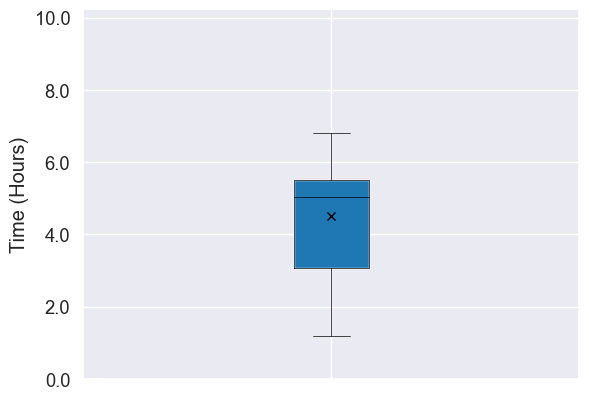

In [473]:
def format_func(value, tick_number):
    return f'{value:.1f}'

formatter = ticker.FuncFormatter(format_func)
  
plotting_function(total_video_time, 'Time (Hours)', 
                  'video_time_statistics', x_label=None, steps_in_data=False, formatter=formatter, 
                  ymin=0, ymax=total_video_time.max() * 1.5)

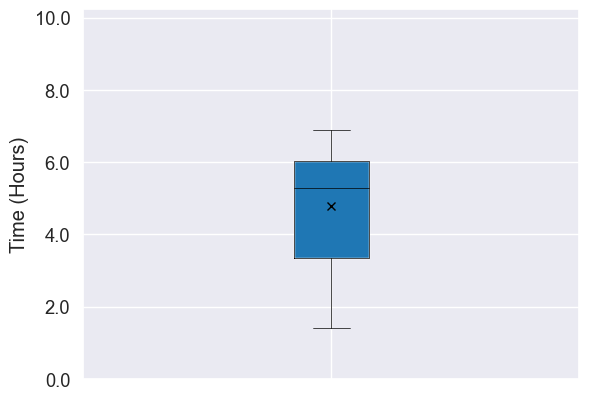

In [594]:
# total time read from opening actual videos
total_time_df = pandas.DataFrame({
    'Video_num':[1,4,6,7,8,9,11,12,13,14,15,16,17,20,21,22,23,24,25,26,27],
    'Total_hours': [6.24, 5.90, 6.82, 6.67, 5.29, 5.63, 3.03, 3.27, 2.55, 4.98, 1.40, 3.69, 6.02, 5.56, 5.41, 6.20, 1.98,
                    6.88, 5.14, 4.80, 3.35]
})
#total_time_df

formatter = ticker.FuncFormatter(format_func)
  
plotting_function(total_time_df['Total_hours'], 'Time (Hours)', 
                  'alt_video_time_statistics', x_label=None, steps_in_data=False, formatter=formatter, 
                  ymin=0, ymax=total_video_time.max() * 1.5)

### Number of videos per step

In [474]:
dataset_df

,approach,number,step,timestamp,current_step_number,new_timestamp,hours,minutes
0,RS,1,rs_approach_and_exposure,00:00:04,p1,1900-01-01 00:00:04,0.001111,0.066667
1,RS,1,rs_tumour_debunking_and_excision,00:02:38,p2,1900-01-01 00:02:38,0.043889,2.633333
2,RS,1,tumour_debulking,00:03:09,1,1900-01-01 00:03:09,0.052500,3.150000
3,RS,1,idle_time,00:04:44,p0,1900-01-01 00:04:44,0.078889,4.733333
4,RS,1,tumour_debulking,00:05:44,1,1900-01-01 00:05:44,0.095556,5.733333
...,...,...,...,...,...,...,...,...
2657,RS,9,idle_time,05:12:51,p0,1900-01-01 05:12:51,5.214167,312.850000
2658,RS,9,tumour_debulking,05:16:13,1,1900-01-01 05:16:13,5.270278,316.216667
2659,RS,9,rs_closure,05:16:18,p3,1900-01-01 05:16:18,5.271667,316.300000
2660,RS,9,idle_time,05:27:57,p0,1900-01-01 05:27:57,5.465833,327.950000


In [475]:
step_data = dataset_df[['number', 'current_step_number']].drop_duplicates().reset_index()
grouped_step_data = step_data.groupby(['current_step_number'])['number'].count().reset_index()
grouped_step_data

,current_step_number,number
0,1,21
1,2,21
2,3,21
3,4,20
4,5,20
5,other,7
6,p0,21
7,p1,21
8,p2,21
9,p3,21


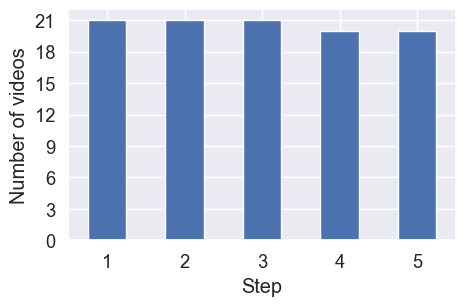

In [476]:
step_data = step_data[~step_data['current_step_number'].isin(['p0', 'p1', 'p2', 'p3', 'other'])]
fig, _ = plt.subplots()
ax = step_data.groupby(['current_step_number'])['number'].count().plot(kind='bar', figsize=(5, 3), width=0.5, 
                                                                       stacked=False, legend=None)

ax.set_ylabel('Number of videos')
ax.set_xlabel('Step')
for label in ax.get_xticklabels():
    label.set_rotation(0)
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

In [477]:
fig.savefig(os.path.join(PATH_FOR_SAVING, 'videos_per_step.png'), bbox_inches='tight')

### Overall time per step

In [20]:
dataset_df

,approach,number,step,timestamp,current_step_number,new_timestamp,hours,minutes
0,RS,1,rs_approach_and_exposure,00:00:04,p1,1900-01-01 00:00:04,0.001111,0.066667
1,RS,1,rs_tumour_debunking_and_excision,00:02:38,p2,1900-01-01 00:02:38,0.043889,2.633333
2,RS,1,tumour_debulking,00:03:09,1,1900-01-01 00:03:09,0.052500,3.150000
3,RS,1,idle_time,00:04:44,p0,1900-01-01 00:04:44,0.078889,4.733333
4,RS,1,tumour_debulking,00:05:44,1,1900-01-01 00:05:44,0.095556,5.733333
...,...,...,...,...,...,...,...,...
2657,RS,9,idle_time,05:12:51,p0,1900-01-01 05:12:51,5.214167,312.850000
2658,RS,9,tumour_debulking,05:16:13,1,1900-01-01 05:16:13,5.270278,316.216667
2659,RS,9,rs_closure,05:16:18,p3,1900-01-01 05:16:18,5.271667,316.300000
2660,RS,9,idle_time,05:27:57,p0,1900-01-01 05:27:57,5.465833,327.950000


In [21]:
time_per_step_df = dataset_df.copy()

In [22]:
time_per_step_df['next_number'] = time_per_step_df['number'].shift(-1)
time_per_step_df['next_step_minutes'] = time_per_step_df['minutes'].shift(-1)
time_per_step_df['time_step_diffs'] = time_per_step_df['next_step_minutes'] - time_per_step_df['minutes']
time_per_step_df['time_step_diffs_seconds'] = time_per_step_df['time_step_diffs'] * 60


In [23]:
# Any time difference < 0 corresponds to the final step. 
# Setting to 0 (for both minnutes and seconds) as the video is just finished by then.
time_per_step_df['time_step_diffs_seconds'] = numpy.where(time_per_step_df['time_step_diffs_seconds'] < 0, 0, time_per_step_df['time_step_diffs_seconds'])
time_per_step_df['time_step_diffs'] = numpy.where(time_per_step_df['time_step_diffs'] < 0, 0, time_per_step_df['time_step_diffs'])

In [24]:
grouped_df = time_per_step_df.groupby(['number', 'current_step_number'])['time_step_diffs'].sum().reset_index()
grouped_df = grouped_df[['number', 'current_step_number', 'time_step_diffs']].sort_values(['number', 'current_step_number'])
#Remove those rows that correspond to the "other" state i.e. these are just notes
grouped_df = grouped_df[~(grouped_df['current_step_number'] == 'other')]

# grouped_df.to_csv(os.path.join(PATH_FOR_SAVING, 'overall_time_per_step.csv'))
# time_per_step_df.to_csv(os.path.join(PATH_FOR_SAVING, 'raw_time_per_step.csv'))
grouped_df

,number,current_step_number,time_step_diffs
0,1,1,76.400000
1,1,2,125.466667
2,1,3,65.450000
3,1,4,34.750000
4,1,p0,52.600000
...,...,...,...
188,27,5,34.983333
190,27,p0,48.283333
191,27,p1,20.366667
192,27,p2,0.000000


In [25]:
data = dict([[str(i), grouped_df[grouped_df['current_step_number']==i]['time_step_diffs'].values] 
             for i in range(1,TOTAL_NUMBER_OF_STEPS+1) ])

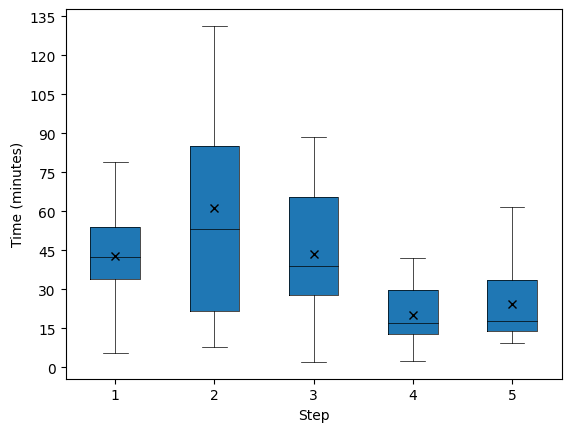

In [26]:
plotting_function(data, 'Time (minutes)', 'Overall_step_duration_minutes', 'Step')

### Individual time per step across all videos

In [485]:
ind_data_seconds = dict([[str(i), time_per_step_df[time_per_step_df['current_step_number']==i]['time_step_diffs_seconds'].values] 
                     for i in range(1,TOTAL_NUMBER_OF_STEPS+1)])
ind_data_minutes = dict([[str(i), time_per_step_df[time_per_step_df['current_step_number']==i]['time_step_diffs'].values] 
                     for i in range(1,TOTAL_NUMBER_OF_STEPS+1)])
ind_data_1fps = dict([[str(i), 1 * time_per_step_df[time_per_step_df['current_step_number']==i]['time_step_diffs_seconds'].values] 
                     for i in range(1,TOTAL_NUMBER_OF_STEPS+1)])
ind_data_5fps = dict([[str(i), 5 * time_per_step_df[time_per_step_df['current_step_number']==i]['time_step_diffs_seconds'].values] 
                     for i in range(1,TOTAL_NUMBER_OF_STEPS+1)])

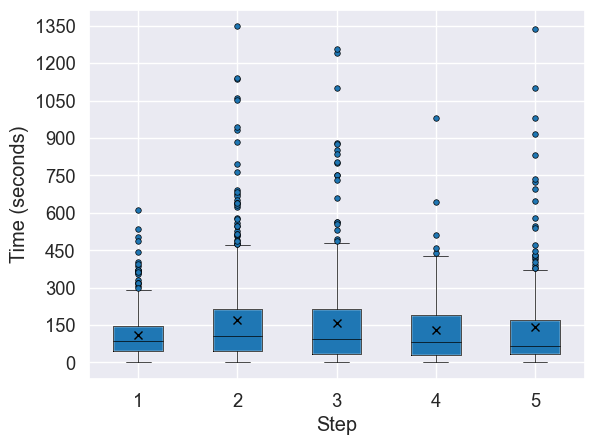

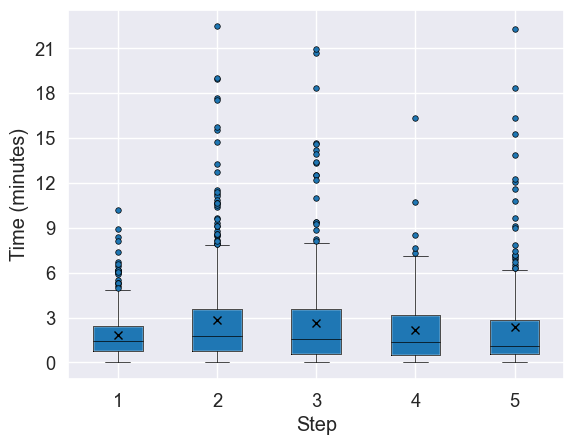

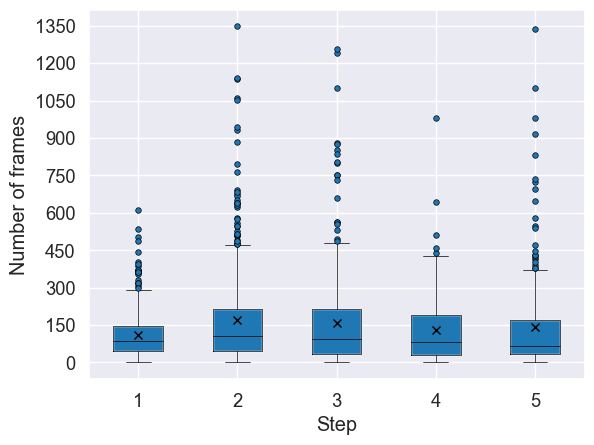

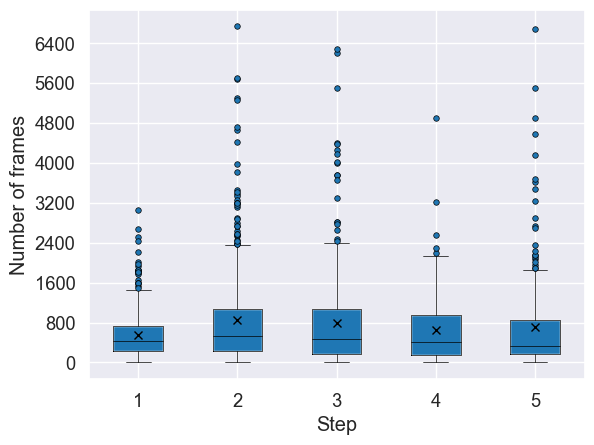

In [486]:
plotting_function(ind_data_seconds, 'Time (seconds)', 'Individual_step_duration_seconds', 'Step')
plotting_function(ind_data_minutes, 'Time (minutes)', 'Individual_step_duration_minutes', 'Step')
plotting_function(ind_data_1fps, 'Number of frames', 'Individual_step_frame_count_1fps', 'Step')
plotting_function(ind_data_5fps, 'Number of frames', 'Individual_step_frame_count_5fps', 'Step')

### Distribution of minimum duration per time step across the videos

In [487]:
min_grouped_df = time_per_step_df.groupby(['number', 'current_step_number'])['time_step_diffs_seconds'].min().reset_index()
min_grouped_df = min_grouped_df[['number', 'current_step_number', 'time_step_diffs_seconds']].sort_values(['number', 'current_step_number'])
#Remove those rows that correspond to the "other" state i.e. these are just notes
min_grouped_df = min_grouped_df[~(min_grouped_df['current_step_number'] == 'other')]


min_data = dict([[str(i), min_grouped_df[min_grouped_df['current_step_number']==i]['time_step_diffs_seconds'].values] 
                for i in range(1,TOTAL_NUMBER_OF_STEPS+1)])
min_data_1fps = dict([[str(i), 1 * min_grouped_df[min_grouped_df['current_step_number']==i]['time_step_diffs_seconds'].values] 
                for i in range(1,TOTAL_NUMBER_OF_STEPS+1)])
min_data_5fps = dict([[str(i), 5 * min_grouped_df[min_grouped_df['current_step_number']==i]['time_step_diffs_seconds'].values] 
                for i in range(1,TOTAL_NUMBER_OF_STEPS+1)])

In [488]:
min_data

{'1': array([20., 16.,  7.,  1., 21.,  5., 41., 82., 26., 29., 40., 34., 26.,
        21., 33.,  9., 53.,  7.,  8.,  6.,  9.]),
 '2': array([14., 12.,  5.,  7.,  0., 18., 29., 20., 44.,  8.,  9., 12., 11.,
         8.,  6.,  9.,  8., 30.,  3.,  1.,  9.]),
 '3': array([ 3.,  4., 13.,  8., 11.,  7., 22.,  9.,  8., 17.,  4.,  7.,  8.,
         5., 26., 27., 11.,  4.,  5., 20., 20.]),
 '4': array([  7.,  17.,   7.,  41.,  27.,  28.,   8.,  15.,  17.,   6.,   3.,
          6.,  18.,   3.,  14., 148.,  22.,   6.,  21.,  24.]),
 '5': array([  2.,   5.,  15.,  20.,  14., 151.,  43., 135.,  15.,  45.,   7.,
        142.,  23.,  22.,  24.,   8.,  11.,  14.,  12.,  29.])}

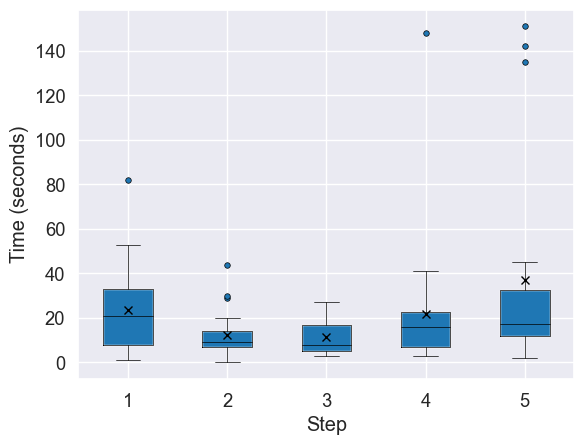

In [489]:
plotting_function(min_data, 'Time (seconds)', 'Min_step_duration_seconds', 'Step')

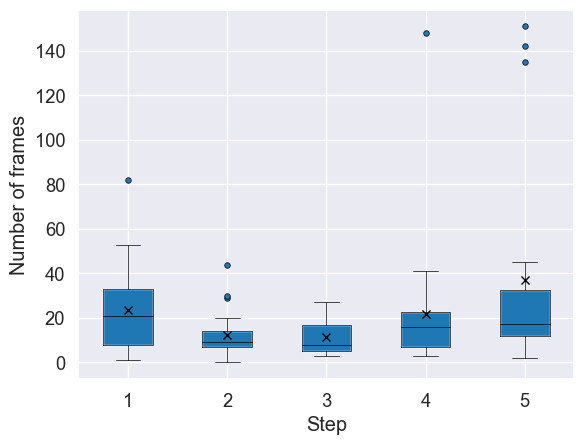

In [490]:
plotting_function(min_data_1fps, 'Number of frames', 'Min_step_framenum_1fps', 'Step')

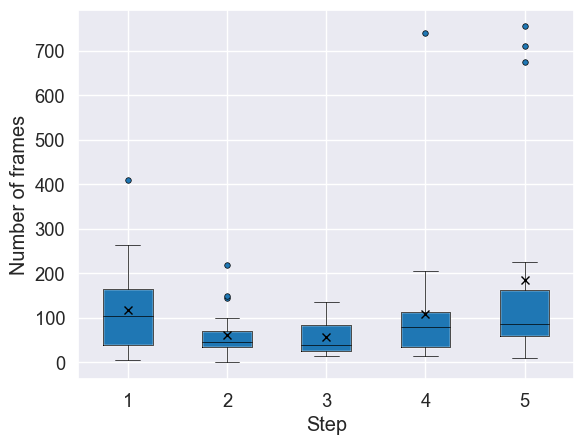

In [491]:
plotting_function(min_data_5fps, 'Number of frames', 'Min_step_framenum_5fps', 'Step')

### Training/testing combinations

In [616]:
grouped_df

,number,current_step_number,time_step_diffs
0,1,1,76.400000
1,1,2,125.466667
2,1,3,65.450000
3,1,4,34.750000
4,1,p0,52.600000
...,...,...,...
188,27,5,34.983333
190,27,p0,48.283333
191,27,p1,20.366667
192,27,p2,0.000000


In [530]:
from itertools import combinations

choose_number = 4
video_num_list = [1, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27]
combinations_list = list(combinations(video_num_list, choose_number))
testing_sets = []

variance_list = []
all_values_list = []
test_combinations = []

for test_set in combinations_list:
    values_list = []
    test_set_str = [str(item) for item in test_set]
    test_grouped_df = grouped_df[(grouped_df['number'].isin(test_set_str)) & 
                           (~grouped_df['current_step_number'].isin(['p0', 'p1', 'p2', 'p3']))]
    variance = numpy.std(test_dist['time_step_diffs'])
    variance_list.append(variance)
    test_dist = test_grouped_df.groupby(['current_step_number'])['time_step_diffs'].mean().reset_index().rename(columns={'time_step_diffs': 'average_time'})

    training_set = [str(item) for item in video_num_list if item not in test_set]
    training_grouped_df = grouped_df[grouped_df['number'].isin(training_set) & 
                           (~grouped_df['current_step_number'].isin(['p0', 'p1', 'p2', 'p3']))]
    training_dist = training_grouped_df.groupby(['current_step_number'])['time_step_diffs'].mean().reset_index().rename(columns={'time_step_diffs': 'average_time'})
    overall_values = list(training_dist['average_time'].values) + list(test_dist['average_time'].values)
    all_values_list.append(overall_values)
    test_combinations.append(test_set)


df = pandas.DataFrame(all_values_list, columns=['Training 1', 'Training 2', 'Training 3', 'Training 4', 'Training 5',
                                                'Testing 1', 'Testing 2', 'Testing 3', 'Testing 4', 'Testing 5'])
df['Test Set'] = test_combinations
df['variance'] = variance_list
df.to_csv(os.path.join(PATH_FOR_SAVING, 'training_testing_combinations.csv'), index=False)
    


In [589]:
df = df.sort_values(['variance']).reset_index().drop(columns='index')
resulting_test_set = df['Test Set'][0]
resulting_test_set

(11, 12, 23, 27)

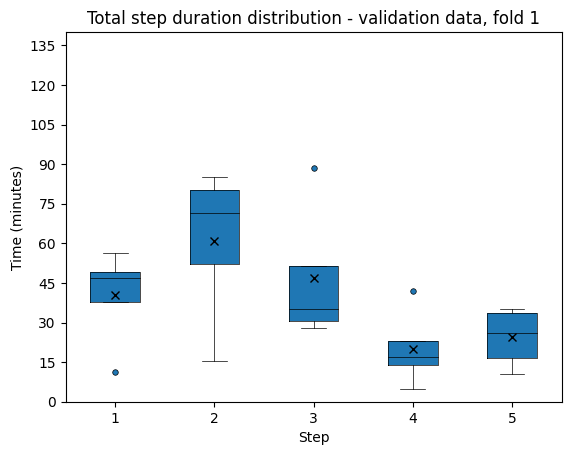

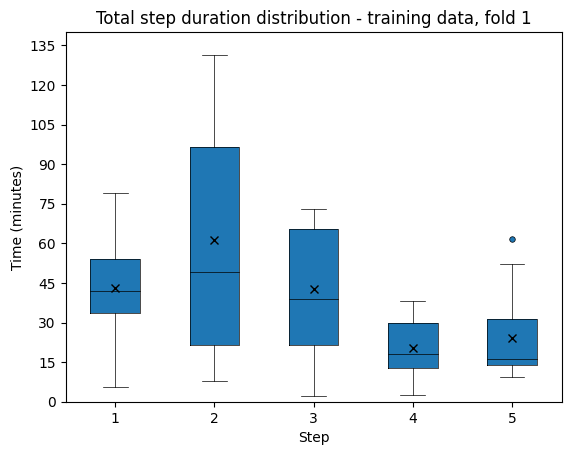

In [38]:
#Selection based on observation of csv file above:
"""
Order by average and std dev
Select the lowest with stddev < 0.07, excluding videos 1 and 15
"""
resulting_test_set = [6, 20, 25, 27]

test_dataset = grouped_df[grouped_df['number'].isin(resulting_test_set)]
training_dataset = grouped_df[~grouped_df['number'].isin(resulting_test_set)]


test_df = dict([[str(i), test_dataset[test_dataset['current_step_number']==i]['time_step_diffs'].values] 
             for i in range(1,TOTAL_NUMBER_OF_STEPS+1) ])

training_df = dict([[str(i), training_dataset[training_dataset['current_step_number']==i]['time_step_diffs'].values] 
             for i in range(1,TOTAL_NUMBER_OF_STEPS+1) ])

plotting_function(test_df, 'Time (minutes)', 'Test_set_step_duration_minutes', 'Step', ymin=0, ymax=140,
                 title = f'Total step duration distribution - validation data, fold 1')
plotting_function(training_df, 'Time (minutes)', 'Training_set_step_duration_minutes', 'Step', ymin=0, ymax=140,
                 title = f'Total step duration distribution - training data, fold 1')


  current_step_number  time_step_diffs
0                   1        40.333333
1                   2        60.837500
2                   3        46.700000
3                   4        20.129167
4                   5        24.375000
5                  p0        76.179167
6                  p1        19.387500
7                  p2         0.041667
8                  p3         5.504167
  current_step_number  time_step_diffs
0                   1        43.200980
1                   2        61.137255
2                   3        42.654902
3                   4        20.195833
4                   5        24.186458
5                  p0        50.247059
6                  p1        18.722549
7                  p2         0.104902
8                  p3         6.243137


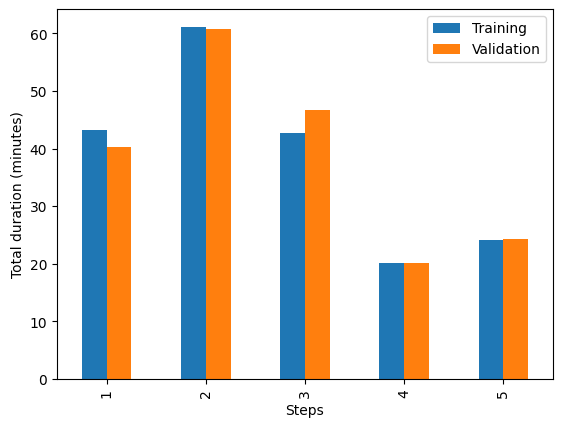

In [39]:
# Plotting average time duration of the different steps in the training dataset and the test dataset
t1 = test_dataset.groupby(['current_step_number'])['time_step_diffs'].mean().reset_index()
t2 = training_dataset.groupby(['current_step_number'])['time_step_diffs'].mean().reset_index()
print(t1)
print(t2)

plot_df = pandas.DataFrame({'Steps':['1', '2', '3', '4', '5'],
                           'Training': t2[t2['current_step_number'].isin([1,2,3,4,5])]['time_step_diffs'].values,
                           'Validation': t1[t1['current_step_number'].isin([1,2,3,4,5])]['time_step_diffs'].values,
                           })
ax = plot_df.set_index('Steps').plot(kind='bar')
ax.set_ylabel('Total duration (minutes)')
plt.savefig(os.path.join(PATH_FOR_SAVING, 'training_test_datasets_split.png'), bbox_inches='tight')

### Remaining cross-validation folds

In [31]:
# (6, 20, 25, 2): Fold 1
# (1, 9, 12, 23): Fold 2
# (7, 13, 16, 21): Fold 3
# (4, 8, 15, 24): Fold 4
# (11, 14, 17, 22, 26): Fold 5

  current_step_number  time_step_diffs
0                   1        43.837500
1                   2        61.212500
2                   3        42.541667
3                   4        20.312500
4                   5        23.722222
5                  p0        41.041667
6                  p1        12.229167
7                  p2         0.137500
8                  p3         2.912500
  current_step_number  time_step_diffs
0                   1        42.376471
1                   2        61.049020
2                   3        43.633333
3                   4        20.150000
4                   5        24.312745
5                  p0        58.514706
6                  p1        20.406863
7                  p2         0.082353
8                  p3         6.852941
  current_step_number  time_step_diffs
0                   1        43.558333
1                   2        61.800000
2                   3        43.737500
3                   4        17.941667
4                   5    

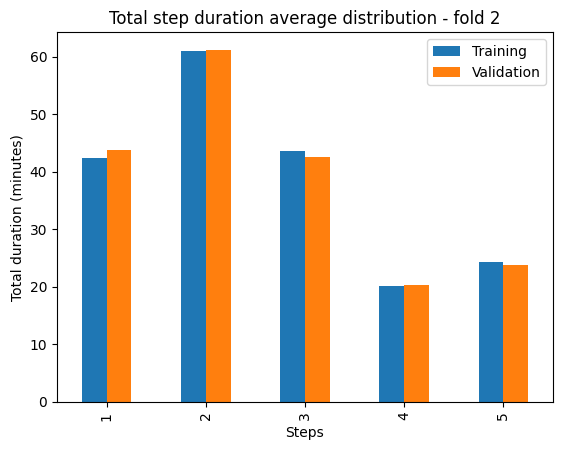

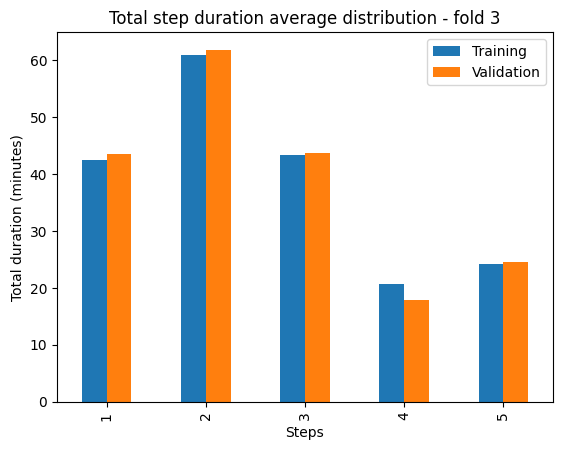

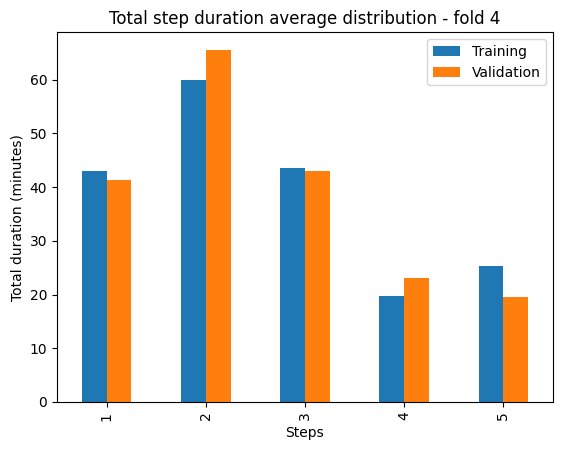

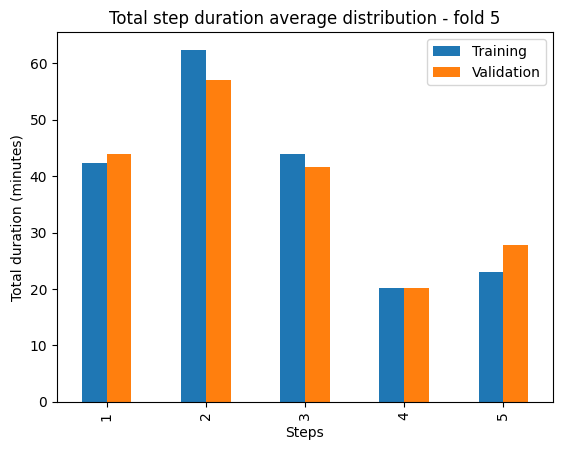

In [37]:
resulting_test_sets = [[1, 9, 12, 23],
                      [7, 13, 16, 21], 
                      [4, 8, 15, 24], 
                      [11, 14, 17, 22, 26]
                     ]

for i, resulting_test_set in enumerate(resulting_test_sets):
    test_dataset = grouped_df[grouped_df['number'].isin(resulting_test_set)]
    training_dataset = grouped_df[~grouped_df['number'].isin(resulting_test_set)]


    test_df = dict([[str(i), test_dataset[test_dataset['current_step_number']==i]['time_step_diffs'].values] 
                 for i in range(1,TOTAL_NUMBER_OF_STEPS+1) ])

    training_df = dict([[str(i), training_dataset[training_dataset['current_step_number']==i]['time_step_diffs'].values] 
                 for i in range(1,TOTAL_NUMBER_OF_STEPS+1) ])

    t1 = test_dataset.groupby(['current_step_number'])['time_step_diffs'].mean().reset_index()
    t2 = training_dataset.groupby(['current_step_number'])['time_step_diffs'].mean().reset_index()
    print(t1)
    print(t2)

    plot_df = pandas.DataFrame({'Steps':['1', '2', '3', '4', '5'],
                               'Training': t2[t2['current_step_number'].isin([1,2,3,4,5])]['time_step_diffs'].values,
                               'Validation': t1[t1['current_step_number'].isin([1,2,3,4,5])]['time_step_diffs'].values,
                               })
    ax = plot_df.set_index('Steps').plot(kind='bar')
    ax.set_ylabel('Total duration (minutes)')
    ax.set_title(f'Total step duration average distribution - fold {i+2}') 
    plt.savefig(os.path.join(PATH_FOR_SAVING, f'training_test_datasets_split_fold{i+2}.png'), bbox_inches='tight')


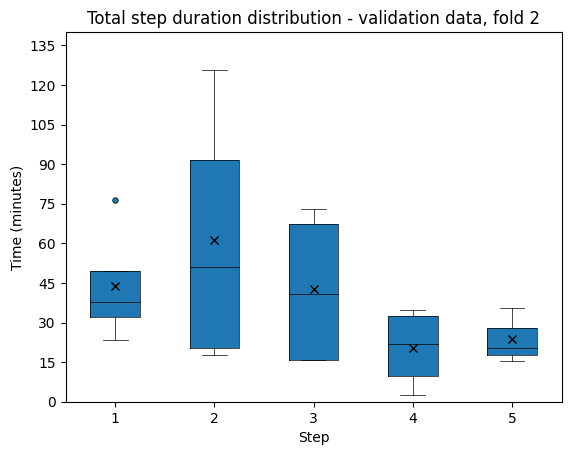

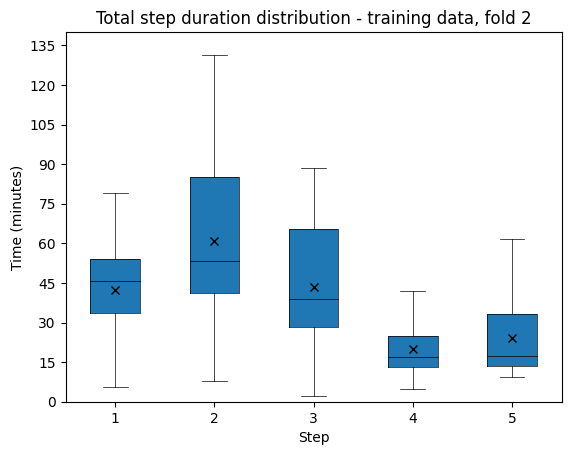

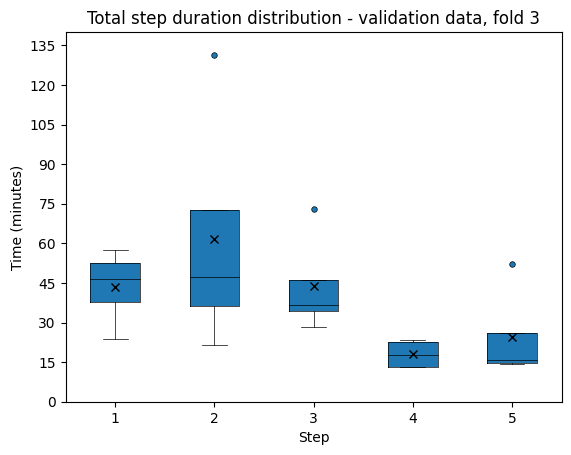

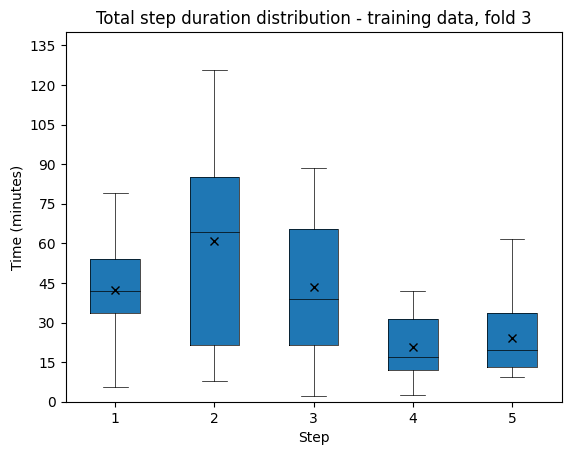

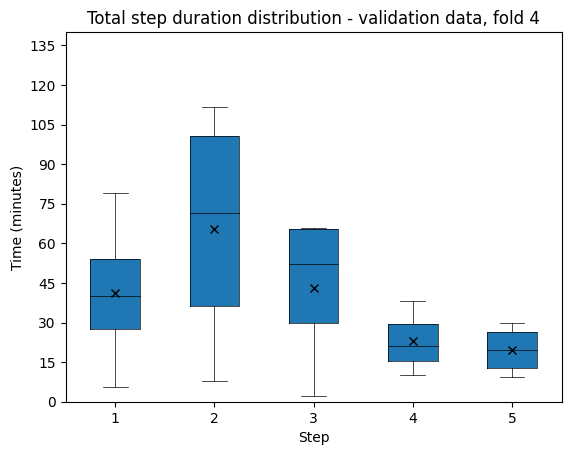

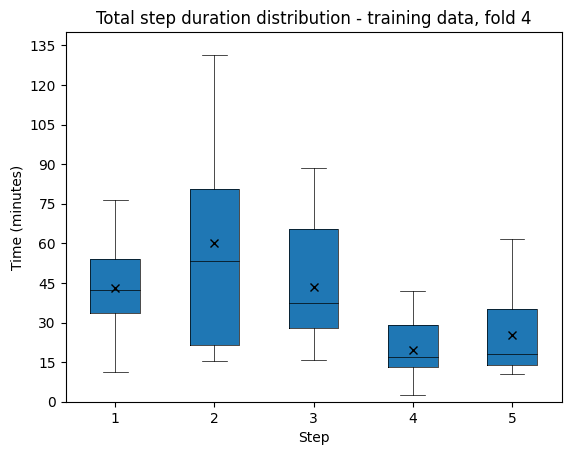

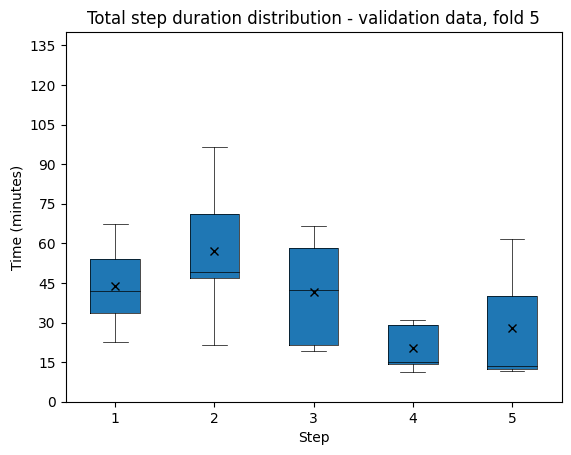

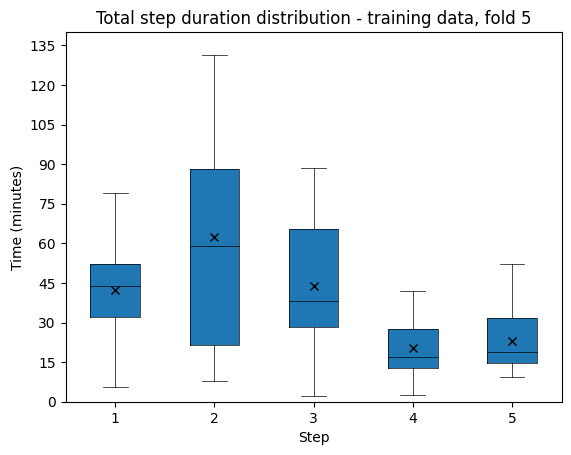

In [36]:
resulting_test_sets = [[1, 9, 12, 23],
                      [7, 13, 16, 21], 
                      [4, 8, 15, 24], 
                      [11, 14, 17, 22, 26]
                     ]
for i, resulting_test_set in enumerate(resulting_test_sets):
    test_dataset = grouped_df[grouped_df['number'].isin(resulting_test_set)]
    training_dataset = grouped_df[~grouped_df['number'].isin(resulting_test_set)]


    test_df = dict([[str(i), test_dataset[test_dataset['current_step_number']==i]['time_step_diffs'].values] 
                 for i in range(1,TOTAL_NUMBER_OF_STEPS+1) ])

    training_df = dict([[str(i), training_dataset[training_dataset['current_step_number']==i]['time_step_diffs'].values] 
                 for i in range(1,TOTAL_NUMBER_OF_STEPS+1) ])

    plotting_function(test_df, 'Time (minutes)', f'Test_set_step_duration_minutes_fold{i+2}', 'Step', ymin=0, ymax=140,
                     title=f'Total step duration distribution - validation data, fold {i+2}')
    plotting_function(training_df, 'Time (minutes)', f'Training_set_step_duration_minutes_fold{i+2}', 'Step', ymin=0, 
                      ymax=140, title=f'Total step duration distribution - training data, fold {i+2}')

### Transition matrix

In [460]:
tm_dataset = dataset_df.copy()
tm_dataset['next_step_number'] = tm_dataset['current_step_number'].shift(-1)
tm_dataset['second_next_step_number'] = tm_dataset['current_step_number'].shift(-2)
tm_dataset['third_next_step_number'] = tm_dataset['current_step_number'].shift(-3)
# Next transition calculation, ignoring any idle states
tm_dataset['next_transition'] = numpy.where(tm_dataset['next_step_number']=='p0',
                                            numpy.where(tm_dataset['second_next_step_number']=='p0', 
                                                       tm_dataset['third_next_step_number'],
                                                       tm_dataset['second_next_step_number']),
                                           tm_dataset['next_step_number'])
# Remove all transitions from the "idle" step (there are no next transition steps that are idle, given logic above)
# Remove all transition from and to "other"
# Remove all transitions from states other than p1 to p1 
tm_df=tm_dataset.groupby(['current_step_number', 'next_transition'])['approach'].count().reset_index()
tm_df = tm_df[~tm_df['current_step_number'].isin(['p0'])]
tm_df = tm_df[~(tm_df['current_step_number'].isin(['other']) | tm_df['next_transition'].isin(['other']))]
tm_df = tm_df[~(~tm_df['current_step_number'].isin(['p1']) & tm_df['next_transition'].isin(['p1']))]

# Remove all phases in current step number or transition except "to p3"
tm_df = tm_df[~(tm_df['current_step_number'].isin(['p0','p1','p2','p3']) | 
                tm_df['next_transition'].isin(['p0','p1','p2']))]
# Missing state required to create the matrix
new_row = {'current_step_number': 3, 'next_transition': 'p3', 'approach': 0}
tm_df = tm_df.append(new_row, ignore_index=True)
tm_df = tm_df.sort_values(['current_step_number', 'next_transition'])
tm_df = tm_df.reset_index().drop('index', axis=1)

tm_array = numpy.array(tm_df['approach']).reshape(5,6)
tm_array
# tm_dataset.to_csv(os.path.join(PATH_FOR_SAVING, 'tm_test_data.csv'))

array([[ 90, 157, 117,  64,  45,  15],
       [162, 118, 103,  55,  14,   1],
       [109, 111,  77,   6,  38,   0],
       [ 63,  57,  15,  32,  16,   1],
       [ 46,  11,  28,  27,  84,   4]])

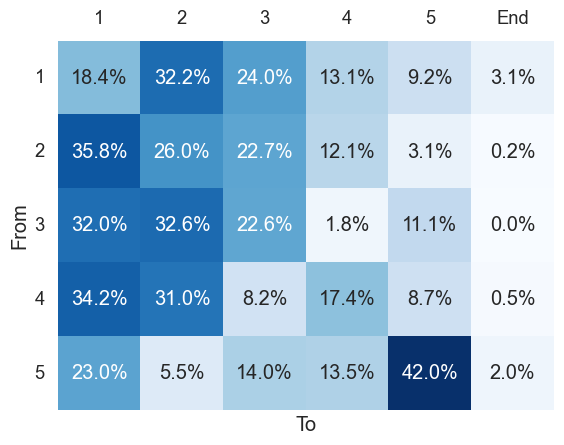

In [615]:
import seaborn as sns

table_df = pandas.DataFrame(tm_array)
table_df.columns = [1, 2, 3, 4, 5, 'End']
table_df.columns.name = 'To'
table_df.index = [1, 2, 3, 4, 5]
table_df.index.name = 'From' 
table_df = table_df.div(table_df.sum(axis=1), axis=0)

df_percent = table_df.applymap(lambda x: '{:.1f}%'.format(x*100))


plt.figure()
sns.set(font_scale=1.2)
# sns.heatmap(table_df, cmap='Blues', annot=True, fmt='.0f', cbar=False) #, cbar_kws={'label': '% accuracy difference'}) #.2% .3f
# sns.heatmap(table_df, cmap='Blues', annot=True, fmt='.3f', cbar=False)
# sns.heatmap(df_percent, cmap='Blues', annot=True, fmt='', cbar=False)
# Create the heatmap
sns.heatmap(table_df, cmap='Blues', annot=df_percent, fmt='', cbar=False)

plt.xlabel('To')
plt.yticks(rotation=0)
plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_tick_params(width=0)



plt.savefig(os.path.join(PATH_FOR_SAVING, 'transition_matrix.png'), bbox_inches='tight')
plt.show()

### Adding extra timestamps in the data

In [1029]:
path = r'/Users/dorotheeduvaux 1/UCL CSML/MSc Project'
filename = 'data_steps.csv'
raw_dataset_df = pandas.read_csv(os.path.join(path, filename))
PATH_FOR_SAVING = r'/Users/dorotheeduvaux 1/UCL CSML/MSc Project/Video analytics'

# removing rows that have duplicate time stamps and cause issues
raw_dataset_df = raw_dataset_df[~raw_dataset_df['step'].isin(['Cystic component opened',
                                                              'Idle time as drilling?', 
                                                              'Drill is being used - Idle time as no label'])]
index_to_exclude1 = raw_dataset_df.loc[(raw_dataset_df['number']==8) 
                   & (raw_dataset_df['step']=='dissection_lateral') 
                   & (raw_dataset_df['timestamp']=='04:34:22')
                  ].index
index_to_exclude2 = raw_dataset_df.loc[(raw_dataset_df['number']==25) 
                   & (raw_dataset_df['step']=='Cannot see surgical field') 
                   & (raw_dataset_df['timestamp']=='03:30:31')
                  ].index
raw_dataset_df = raw_dataset_df.drop(index_to_exclude1) 
raw_dataset_df = raw_dataset_df.drop(index_to_exclude2) 
raw_dataset_df

pandas_lists = []
df = raw_dataset_df.copy()
df['step_number'] = df['step'].map(step_map).fillna("other") 
df['timestamp'] = pandas.to_datetime(df['timestamp'])
video_nums = df['number'].drop_duplicates().values
df

,approach,number,step,timestamp,step_number
0,RS,1,rs_approach_and_exposure,2023-07-09 00:00:04,p1
1,RS,1,rs_tumour_debunking_and_excision,2023-07-09 00:02:38,p2
2,RS,1,tumour_debulking,2023-07-09 00:03:09,1
3,RS,1,idle_time,2023-07-09 00:04:44,p0
4,RS,1,tumour_debulking,2023-07-09 00:05:44,1
...,...,...,...,...,...
2657,RS,9,idle_time,2023-07-09 05:12:51,p0
2658,RS,9,tumour_debulking,2023-07-09 05:16:13,1
2659,RS,9,rs_closure,2023-07-09 05:16:18,p3
2660,RS,9,idle_time,2023-07-09 05:27:57,p0


In [1030]:
step_map = {
    'tumour_debulking':1,
    'dissection_medial':2,
    'dissection_inferior':3,
    'dissection_superior':4,
    'dissection_lateral':5,
    'idle_time':'p0',
    'rs_approach_and_exposure':'p1',
    'rs_tumour_debunking_and_excision': 'p2',
    'rs_closure': 'p3',
}

#### Take in the total timestamp of each video and construct a frame column
overall_total_timestamp = {
    1:  '06:14:19',
    4:  '05:54:02',
    6:  '06:49:20',
    7:  '06:40:15',
    8:  '05:17:33',
    9:  '05:37:32',
    11: '03:01:30',
    12: '03:16:10',
    13: '02:32:50',
    14: '04:58:50',
    15: '01:24:16',
    16: '03:41:07',
    17: '06:01:18',
    20: '05:33:36',
    21: '05:24:28',
    22: '06:11:55',
    23: '01:58:34',
    24: '06:52:36',
    25: '05:08:07',
    26: '04:47:45',
    27: '03:21:16',
}


In [1031]:
def adjust_frame_folder_string(value, item):
    path = r'/Users/dorotheeduvaux 1/UCL CSML/MSc Project'
    video_num = '0' + str(item) if item < 10 else str(item) 
    overall_path = os.path.join(path, 'RS_data/video_outputs', str(item), f'video{video_num}_{value}.png')
    return overall_path

In [1032]:
# Note that I'm cutting off the last step just before the closure. Need to sort that out at some point!
for item in video_nums:
    try:
        data = df[df['number'] == item]
        data = data.sort_values('timestamp').reset_index().drop(columns='index')

        # cut off exposure phase and closure phase
        excision_step = data[data['step'] == 'rs_tumour_debunking_and_excision'].index.values[0]
        closure_step = data[data['step'] == 'rs_closure'].index.values[0]
        data = data.loc[excision_step+1:closure_step-1].reset_index().drop(columns='index')

        # sample at 1fps
        data = data.set_index('timestamp')
        data = data.resample('1s').ffill()

        # map extracted frames at 5fps to the 1fps dataframe
        time_data = pandas.DataFrame({'timestamp': [pandas.to_datetime('00:00:00'), 
                                       pandas.to_datetime(overall_total_timestamp[item])]})
        time_data = time_data.set_index('timestamp')
        time_data = time_data.resample('200ms').ffill()
        time_data['frame_number'] = [str(i).zfill(6) for i in range(1, len(time_data)+1)]
        time_data['frame_number'] = time_data['frame_number'].apply(adjust_frame_folder_string, args=(item,))

        # Join on the file location
        data = pandas.merge(data, time_data, on='timestamp', how='left')

        # restrict to the steps that we are interested in + formatting
        data = data[data['step_number'].isin([1,2,3,4,5])].reset_index()
        data['timestamp'] = data['timestamp'].dt.time
        
        pandas_lists.append(data)
    except Exception as e:
        print(f"Problem with video {item}: ", e)
    
    
result = pandas.concat(pandas_lists)
result.to_csv(os.path.join(PATH_FOR_SAVING, 'reduced_frames_data.csv'), index=False)

In [1048]:
steps_weights = result.groupby(['step', 'step_number'])['approach'].count().reset_index()
steps_weights['weights'] = steps_weights['approach']/steps_weights['approach'].sum(axis=0) 
steps_weights = steps_weights.rename(columns={'approach':'counts'})

steps_weights.sort_values('step_number').reset_index().drop(columns='index', axis=1)

,step,step_number,counts,weights
0,tumour_debulking,1,53325,0.225290
1,dissection_medial,2,77001,0.325317
2,dissection_inferior,3,54310,0.229451
3,dissection_superior,4,23632,0.099842
4,dissection_lateral,5,28427,0.120100


In [1055]:
import shutil
import os
from pathlib import Path

def move_file(src_file, dest_folder):
    # Ensure destination folder exists
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    # move file to new directory
    shutil.move(src_file, dest_folder)

files = result['frame_number'].values

for file in files:
    destination_folder = Path(str(Path(file).parent).replace('video_outputs','final_frames'))
    try:
        #Note that the data was moved but it should really have been copied. Otherwise, it will be difficult to keep 
        #track of this "golden" source copy.
        #shutil.copy(file, destination_folder)
        move_file(file, destination_folder)
    except Exception as e:
        print(e)

# Note that total size is 48 GB

Destination path '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/final_frames/1/video01_000946.png' already exists


In [1067]:
source_folder = Path('/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/final_frames')
destination_folder = Path('/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs')
folders = [item for item in os.listdir(source_folder) if item != '.DS_Store']
print(folders)

['20', '27', '9', '11', '7', '16', '6', '17', '1', '26', '8', '21', '24', '23', '4', '15', '12', '13', '14', '22', '25']


In [1070]:
for folder in ['7', '16', '6', '17', '1', '26', '8', '21', '24', '23', '4', '15', '12', '13', '14', '22', '25']: #folders:
    files = os.listdir(os.path.join(source_folder, folder))
    for file in files:
        source_path = os.path.join(source_folder, folder, file)
        destination_path = os.path.join(destination_folder, folder, file)
        try:
#             print(file)
#             print(folder)
#             print(source_path)
#             print(destination_path)
            shutil.copy(source_path, destination_path)
        except Exception as e:
            print(e)

### Creating a pkl file

In [40]:
frames = pandas.read_csv(os.path.join(PATH_FOR_SAVING, 'reduced_frames_data.csv'))

In [41]:
frames

,Unnamed: 0,timestamp,approach,number,step,step_number,frame_number
0,0,00:03:09,RS,1,tumour_debulking,1,/Users/dorotheeduvaux 1/UCL CSML/MSc Project/R...
1,1,00:03:10,RS,1,tumour_debulking,1,/Users/dorotheeduvaux 1/UCL CSML/MSc Project/R...
2,2,00:03:11,RS,1,tumour_debulking,1,/Users/dorotheeduvaux 1/UCL CSML/MSc Project/R...
3,3,00:03:12,RS,1,tumour_debulking,1,/Users/dorotheeduvaux 1/UCL CSML/MSc Project/R...
4,4,00:03:13,RS,1,tumour_debulking,1,/Users/dorotheeduvaux 1/UCL CSML/MSc Project/R...
...,...,...,...,...,...,...,...
236690,14504,05:12:47,RS,9,tumour_debulking,1,/Users/dorotheeduvaux 1/UCL CSML/MSc Project/R...
236691,14505,05:12:48,RS,9,tumour_debulking,1,/Users/dorotheeduvaux 1/UCL CSML/MSc Project/R...
236692,14506,05:12:49,RS,9,tumour_debulking,1,/Users/dorotheeduvaux 1/UCL CSML/MSc Project/R...
236693,14507,05:12:50,RS,9,tumour_debulking,1,/Users/dorotheeduvaux 1/UCL CSML/MSc Project/R...


In [42]:
frames['frame_number'][0]
def modify_frame_name(value):
    new_value = value.replace('/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs',
                              '/home/dorothee/RS_data/final_frames')
    return new_value

In [43]:
frames['frame_number'] = frames['frame_number'].apply(modify_frame_name)

In [44]:
frames['step_number'] = frames['step_number']-1

In [45]:
video_nums = frames['number'].drop_duplicates().values

In [46]:
video_nums

array([ 1, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27,  4,
        6,  7,  8,  9])

In [1140]:
## Option 1 (17/4)
import pickle 

# TODO: amend the path name if I'm running on the server

train_num = []
train_paths = []
train_labels = []
test_num = []
test_paths = []
test_labels = []
val_num = []
val_paths = []
val_labels = []

validation_dataset = [6, 20, 25, 27]
test_dataset = [6, 20, 25, 27]
total_testing_dataset = list(set(validation_dataset + test_dataset))
training_dataset = [video for video in video_nums if video not in total_testing_dataset]

for video in video_nums:
    data = frames[frames['number']==video]
    if video in training_dataset:
        train_num.append(len(data))
        train_paths.extend(data['frame_number'].values)
        train_labels.extend(data['step_number'].values)
    if video in validation_dataset:
        val_num.append(len(data))
        val_paths.extend(data['frame_number'].values)
        val_labels.extend(data['step_number'].values)
    if video in test_dataset:
        test_num.append(len(data))
        test_paths.extend(data['frame_number'].values)
        test_labels.extend(data['step_number'].values)

train_val_test_paths_labels = []
train_val_test_paths_labels.append(train_paths)
train_val_test_paths_labels.append(val_paths)

train_val_test_paths_labels.append(train_labels)
train_val_test_paths_labels.append(val_labels)

train_val_test_paths_labels.append(train_num)
train_val_test_paths_labels.append(val_num)

train_val_test_paths_labels.append(test_paths)
train_val_test_paths_labels.append(test_labels)
train_val_test_paths_labels.append(test_num)

with open(os.path.join(PATH_FOR_SAVING,'server_train_val_paths_labels.pkl'), 'wb') as f:
    pickle.dump(train_val_test_paths_labels, f)

### Cross-validation folds (2, 3, 4, 5)

In [51]:
# Fold 1: (6 20 25 27)
# Fold 2:(1, 9, 12, 23)
# Fold 3: (7, 13, 16, 21)
# Fold 4: (4, 8, 15, 24)
# Fold 5: (11, 14, 17, 22, 26)

import pickle 

train_num = []
train_paths = []
train_labels = []
test_num = []
test_paths = []
test_labels = []
val_num = []
val_paths = []
val_labels = []

validation_dataset = [11, 14, 17, 22, 26] # [1, 9, 12, 23]
test_dataset = [11, 14, 17, 22, 26]
total_testing_dataset = list(set(validation_dataset + test_dataset))
training_dataset = [video for video in video_nums if video not in total_testing_dataset]

for video in video_nums:
    data = frames[frames['number']==video]
    if video in training_dataset:
        train_num.append(len(data))
        train_paths.extend(data['frame_number'].values)
        train_labels.extend(data['step_number'].values)
    if video in validation_dataset:
        val_num.append(len(data))
        val_paths.extend(data['frame_number'].values)
        val_labels.extend(data['step_number'].values)
    if video in test_dataset:
        test_num.append(len(data))
        test_paths.extend(data['frame_number'].values)
        test_labels.extend(data['step_number'].values)

train_val_test_paths_labels = []
train_val_test_paths_labels.append(train_paths)
train_val_test_paths_labels.append(val_paths)

train_val_test_paths_labels.append(train_labels)
train_val_test_paths_labels.append(val_labels)

train_val_test_paths_labels.append(train_num)
train_val_test_paths_labels.append(val_num)

train_val_test_paths_labels.append(test_paths)
train_val_test_paths_labels.append(test_labels)
train_val_test_paths_labels.append(test_num)

with open(os.path.join(PATH_FOR_SAVING,'server_train_val_paths_labels_fold5.pkl'), 'wb') as f:
    pickle.dump(train_val_test_paths_labels, f)

In [13]:
# Option 2 (17/2/2)
import pickle 

# TODO: amend the path name if I'm running on the server

train_num = []
train_paths = []
train_labels = []
test_num = []
test_paths = []
test_labels = []
val_num = []
val_paths = []
val_labels = []

validation_dataset = [6, 27]
test_dataset = [20, 25]
total_testing_dataset = list(set(validation_dataset + test_dataset))
training_dataset = [video for video in video_nums if video not in total_testing_dataset]

for video in video_nums:
    data = frames[frames['number']==video]
    if video in training_dataset:
        train_num.append(len(data))
        train_paths.extend(data['frame_number'].values)
        train_labels.extend(data['step_number'].values)
    if video in validation_dataset:
        val_num.append(len(data))
        val_paths.extend(data['frame_number'].values)
        val_labels.extend(data['step_number'].values)
    if video in test_dataset:
        test_num.append(len(data))
        test_paths.extend(data['frame_number'].values)
        test_labels.extend(data['step_number'].values)

train_val_test_paths_labels = []
train_val_test_paths_labels.append(train_paths)
train_val_test_paths_labels.append(val_paths)

train_val_test_paths_labels.append(train_labels)
train_val_test_paths_labels.append(val_labels)

train_val_test_paths_labels.append(train_num)
train_val_test_paths_labels.append(val_num)

train_val_test_paths_labels.append(test_paths)
train_val_test_paths_labels.append(test_labels)
train_val_test_paths_labels.append(test_num)

with open(os.path.join(PATH_FOR_SAVING,'server_train_val_paths_labels_17_2_2.pkl'), 'wb') as f:
    pickle.dump(train_val_test_paths_labels, f)

In [14]:
# Option 3 (16/1/4)
import pickle 

# TODO: amend the path name if I'm running on the server

train_num = []
train_paths = []
train_labels = []
test_num = []
test_paths = []
test_labels = []
val_num = []
val_paths = []
val_labels = []

validation_dataset = [16]
test_dataset = [6, 20, 25, 27]

total_testing_dataset = list(set(validation_dataset + test_dataset))
training_dataset = [video for video in video_nums if video not in total_testing_dataset]

for video in video_nums:
    data = frames[frames['number']==video]
    if video in training_dataset:
        train_num.append(len(data))
        train_paths.extend(data['frame_number'].values)
        train_labels.extend(data['step_number'].values)
    if video in validation_dataset:
        val_num.append(len(data))
        val_paths.extend(data['frame_number'].values)
        val_labels.extend(data['step_number'].values)
    if video in test_dataset:
        test_num.append(len(data))
        test_paths.extend(data['frame_number'].values)
        test_labels.extend(data['step_number'].values)

train_val_test_paths_labels = []
train_val_test_paths_labels.append(train_paths)
train_val_test_paths_labels.append(val_paths)

train_val_test_paths_labels.append(train_labels)
train_val_test_paths_labels.append(val_labels)

train_val_test_paths_labels.append(train_num)
train_val_test_paths_labels.append(val_num)

train_val_test_paths_labels.append(test_paths)
train_val_test_paths_labels.append(test_labels)
train_val_test_paths_labels.append(test_num)

with open(os.path.join(PATH_FOR_SAVING,'server_train_val_paths_labels_16_1_4.pkl'), 'wb') as f:
    pickle.dump(train_val_test_paths_labels, f)

### Dummy test file

In [1102]:
train_num = [40]
train_paths = [
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000201.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000104.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000085.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000054.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000235.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000731.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000158.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000104.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000946.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000981.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_001065.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_001074.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_037824.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_065572.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_037901.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_004583.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_004779.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_005337.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_074969.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_078640.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_083661.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_088556.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_106557.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_082603.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_003561.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_073114.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_007274.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_033757.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_033631.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_047826.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_045804.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_040939.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_004834.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_011460.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_012549.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_013071.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_025069.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_027616.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_028959.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_062927.png',
]
train_labels = [
    5,
    5,
    5,
    5,
    5,
    5,
    5,
    5,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    3,
    3,
    3,
    3,
    3,
    3,
    3,
    3,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    4,
    4,
    4,
    4,
    4,
    4,
    4,
    4,
]
test_num = [20]
test_paths = [
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000439.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000435.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000002.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000550.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_004452.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_002033.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_001754.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000959.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_055552.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_049922.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_004921.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_104856.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_003599.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_007329.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_014549.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_073140.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_094736.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_094776.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_098361.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_025103.png',
]

test_labels = [
    5,
    5,
    5,
    5,
    1,
    1,
    1,
    1,
    3,
    3,
    3,
    3,
    2,
    2,
    2,
    2,
    4,
    4,
    4,
    4,
]

val_num = [20]
val_paths = [
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000595.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000088.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000139.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000539.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_091769.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_107335.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_069488.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_051588.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_055528.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_022015.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_004777.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_106895.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_018552.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_033754.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_038815.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_046463.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_098484.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_099901.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_027683.png',
    '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_027730.png',
]
val_labels = [
    5,
    5,
    5,
    5,
    1,
    1,
    1,
    1,
    3,
    3,
    3,
    3,
    2,
    2,
    2,
    2,
    4,
    4,
    4,
    4,
]


In [1103]:
print(train_labels)
train_labels = [item-1 for item in train_labels]
print(train_labels)

print(val_labels)
val_labels = [item-1 for item in val_labels]
print(val_labels)

print(test_labels)
test_labels = [item-1 for item in test_labels]
print(test_labels)

[5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3]
[5, 5, 5, 5, 1, 1, 1, 1, 3, 3, 3, 3, 2, 2, 2, 2, 4, 4, 4, 4]
[4, 4, 4, 4, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 1, 1, 3, 3, 3, 3]
[5, 5, 5, 5, 1, 1, 1, 1, 3, 3, 3, 3, 2, 2, 2, 2, 4, 4, 4, 4]
[4, 4, 4, 4, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 1, 1, 3, 3, 3, 3]


In [1104]:
dummy_train_val_test_paths_labels = []
dummy_train_val_test_paths_labels.append(train_paths)
dummy_train_val_test_paths_labels.append(val_paths)

dummy_train_val_test_paths_labels.append(train_labels)
dummy_train_val_test_paths_labels.append(val_labels)

dummy_train_val_test_paths_labels.append(train_num)
dummy_train_val_test_paths_labels.append(val_num)

dummy_train_val_test_paths_labels.append(test_paths)
dummy_train_val_test_paths_labels.append(test_labels)
dummy_train_val_test_paths_labels.append(test_num)

with open(os.path.join(PATH_FOR_SAVING,'dummy_train_val_paths_labels.pkl'), 'wb') as f:
    pickle.dump(dummy_train_val_test_paths_labels, f)

### Creation of dummy dataset

In [1119]:
import shutil
import os
from pathlib import Path

    
all_files = train_paths + test_paths + val_paths
for source_path in all_files:
    destination_folder = Path(source_path.replace('video_outputs', 'dummy_dataset')) 
    try:
        #print(path, destination_folder)
        shutil.copy(source_path, destination_folder)
    except Exception as e:
        print(e)


In [1121]:
def modify_path_string(path_list):
    new_path_list = []
    for path in path_list:
        new_path = path.replace('/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs', 
                                '/home/dorothee/RS_data/dummy_dataset')
        new_path_list.append(new_path)
    return new_path_list

print(modify_path_string(train_paths))
print(modify_path_string(val_paths))
print(modify_path_string(test_paths))

dummy_train_val_test_paths_labels = []
dummy_train_val_test_paths_labels.append(modify_path_string(train_paths))
dummy_train_val_test_paths_labels.append(modify_path_string(val_paths))

dummy_train_val_test_paths_labels.append(train_labels)
dummy_train_val_test_paths_labels.append(val_labels)

dummy_train_val_test_paths_labels.append(train_num)
dummy_train_val_test_paths_labels.append(val_num)

dummy_train_val_test_paths_labels.append(modify_path_string(test_paths))
dummy_train_val_test_paths_labels.append(test_labels)
dummy_train_val_test_paths_labels.append(test_num)

with open(os.path.join(PATH_FOR_SAVING,'server_dummy_train_val_paths_labels.pkl'), 'wb') as f:
    pickle.dump(dummy_train_val_test_paths_labels, f)


['/home/dorothee/RS_data/dummy_dataset/1/video01_000201.png', '/home/dorothee/RS_data/dummy_dataset/1/video01_000104.png', '/home/dorothee/RS_data/dummy_dataset/1/video01_000085.png', '/home/dorothee/RS_data/dummy_dataset/1/video01_000054.png', '/home/dorothee/RS_data/dummy_dataset/1/video01_000235.png', '/home/dorothee/RS_data/dummy_dataset/1/video01_000731.png', '/home/dorothee/RS_data/dummy_dataset/1/video01_000158.png', '/home/dorothee/RS_data/dummy_dataset/1/video01_000104.png', '/home/dorothee/RS_data/dummy_dataset/1/video01_000946.png', '/home/dorothee/RS_data/dummy_dataset/1/video01_000981.png', '/home/dorothee/RS_data/dummy_dataset/1/video01_001065.png', '/home/dorothee/RS_data/dummy_dataset/1/video01_001074.png', '/home/dorothee/RS_data/dummy_dataset/1/video01_037824.png', '/home/dorothee/RS_data/dummy_dataset/1/video01_065572.png', '/home/dorothee/RS_data/dummy_dataset/1/video01_037901.png', '/home/dorothee/RS_data/dummy_dataset/1/video01_004583.png', '/home/dorothee/RS_data

### Visualisations

In [118]:
overall_total_timestamp = {
    1:  '06:14:19',
    4:  '05:54:02',
    6:  '06:49:20',
    7:  '06:40:15',
    8:  '05:17:33',
    9:  '05:37:32',
    11: '03:01:30',
    12: '03:16:10',
    13: '02:32:50',
    14: '04:58:50',
    15: '01:24:16',
    16: '03:41:07',
    17: '06:01:18',
    20: '05:33:36',
    21: '05:24:28',
    22: '06:11:55',
    23: '01:58:34',
    24: '06:52:36',
    25: '05:08:07',
    26: '04:47:45',
    27: '03:21:16',
}


adj_step_map = { 
    'tumour_debulking': 0,
    'dissection_medial': 1,
    'dissection_inferior': 2,
    'dissection_superior': 3, 
    'dissection_lateral': 4,
    'end': 'end',
}


colors = {
    0: 'blue', # tumour debulking
    1: 'green', # dissection medial
    2: 'red', # dissection inferior
    3: 'skyblue', # dissection superior
    4: 'orange', # dissection lateral
    'other': 'gray',
    'end': 'gray',
}

In [127]:
import pandas
import os
import numpy
from matplotlib.patches import Rectangle

path = r'/Users/dorotheeduvaux 1/UCL CSML/MSc Project'
input_file = os.path.join(path, 'data_steps.csv')
#input_file = os.path.join(PATH_FOR_SAVING, 'reduced_frames_data.csv')
df = pandas.read_csv(input_file)
video_nums = df['number'].drop_duplicates()



/Users/dorotheeduvaux 1/PycharmProjects/myPlayground/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


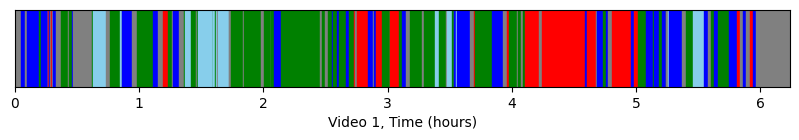

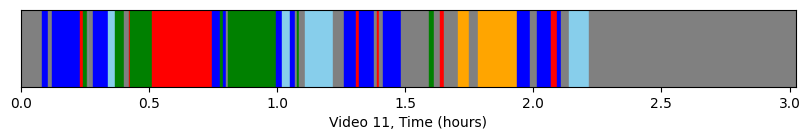

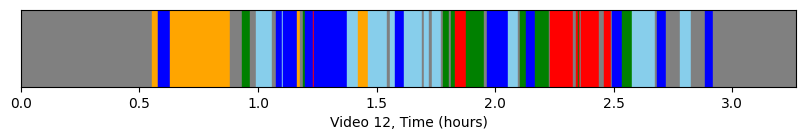

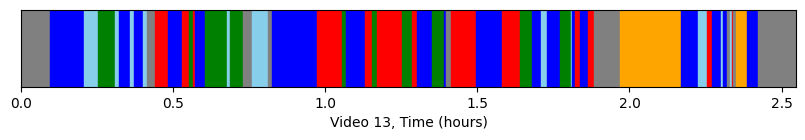

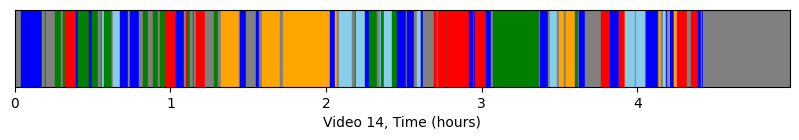

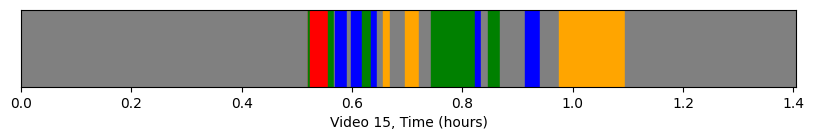

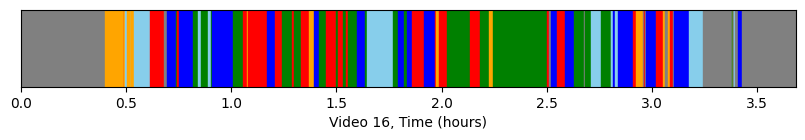

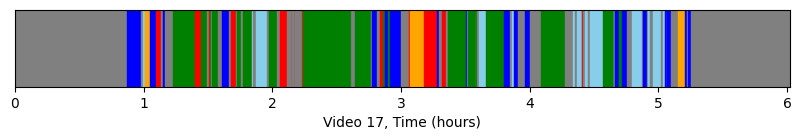

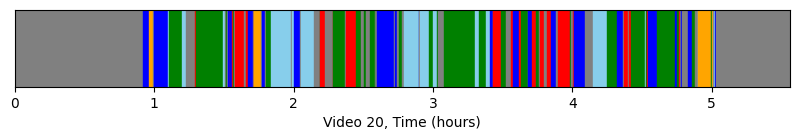

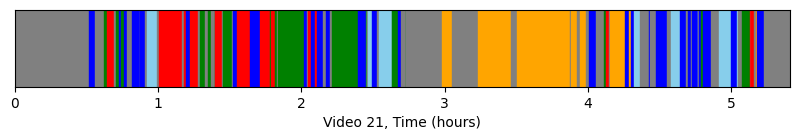

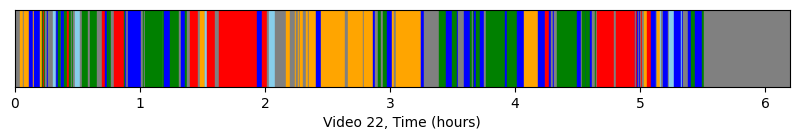

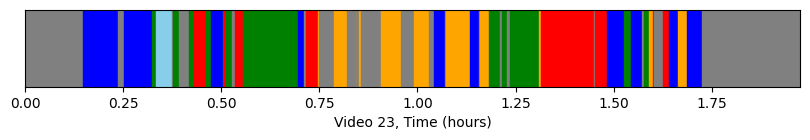

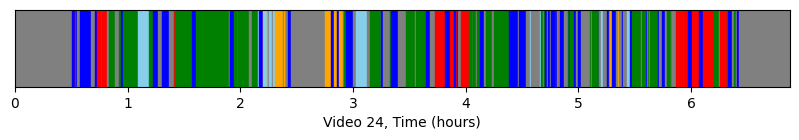

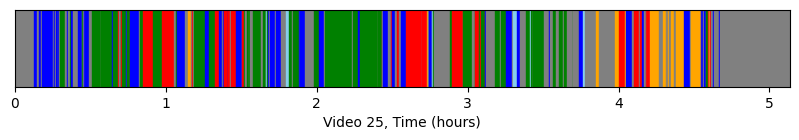

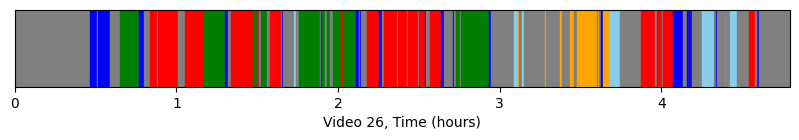

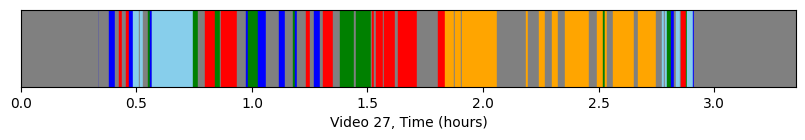

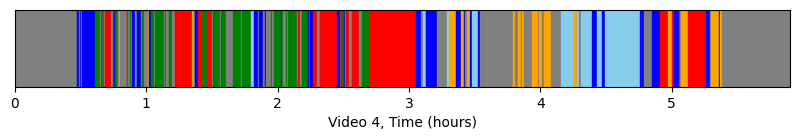

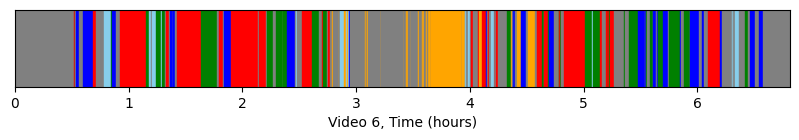

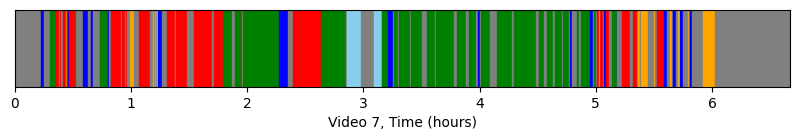

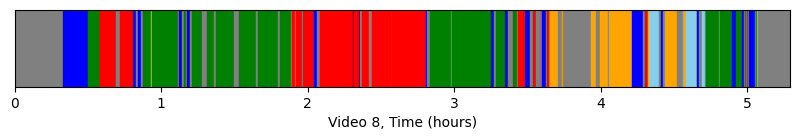

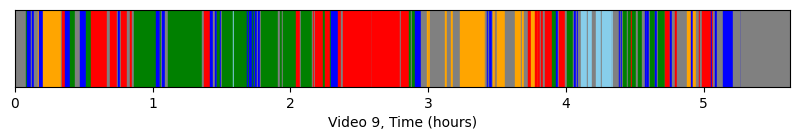

In [130]:
for video_num in video_nums:

    data = df[df['number'] == video_num]
    final_timestamp = overall_total_timestamp[video_num]
    data = data.append({'approach':'RS','number': video_num, 'step':'end', 'timestamp': final_timestamp}, ignore_index=True)

    data['diff'] = pandas.to_datetime(data['timestamp'].shift(-1), format='%H:%M:%S') - pandas.to_datetime(data['timestamp'], format='%H:%M:%S') 
    data['number_of_hours'] = data['diff']/pandas.Timedelta(hours=1)
    data = data.reset_index()
    data_length = len(data)
    data['step_number'] = data['step'].map(adj_step_map).fillna("other") 

    height = 0.5
    # Create figure and specify the colors for each phase
    fig, ax = plt.subplots(figsize=[10, 1])

    start = 0 
    previous_step = data.loc[0, 'step_number']
    duration = data.loc[0, 'number_of_hours']


    for row_num in range(1, data_length):
        if data.loc[row_num, 'step_number'] == previous_step:
            # start does not change since you are not switching to next step yet
            # duration adds up though
            duration += data.loc[row_num, 'number_of_hours']
        else:
            # if step is no longer the same, then you should plot the previous step:
    #         print('start: ', start)
    #         print('duration: ', duration)
    #         print('step: ', previous_step, '\n')
            ax.add_patch(
                Rectangle((start, 0), duration, height, color=colors[previous_step]))  # , label=previous_step))
            # Then next start date becomes start + cumulative duration up until now
            # duration resets to current duration
            # previous_step resets to new step
            start += duration
            duration = data.loc[row_num, 'number_of_hours']
            previous_step = data.loc[row_num, 'step_number']


    # Set the limits and labels of the plot
    ax.set_xlim(0, start)
    ax.set_ylim(0, height)
    ax.set_yticks([])  # hide the y-axis
    ax.set_xlabel(f'Video {video_num}, Time (hours)')

    # Place the legend outside of the plot
    #ax.legend(bbox_to_anchor=(1.05, 1.4))

    plt.savefig(os.path.join(PATH_FOR_SAVING, f'timeline_{video_num}.png'), bbox_inches='tight')

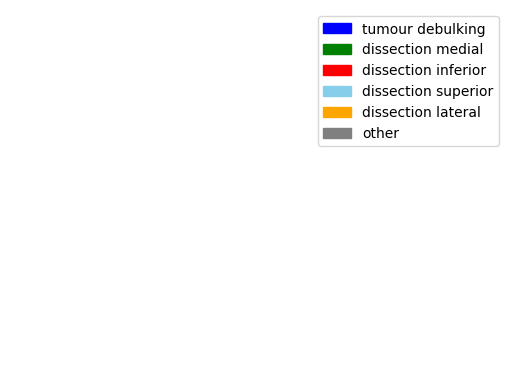

In [134]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Create patches
blue_patch = mpatches.Patch(color='blue', label='tumour debulking')
green_patch = mpatches.Patch(color='green', label='dissection medial')
red_patch = mpatches.Patch(color='red', label='dissection inferior')
skyblue_patch = mpatches.Patch(color='skyblue', label='dissection superior')
orange_patch = mpatches.Patch(color='orange', label='dissection lateral')
gray_patch = mpatches.Patch(color='gray', label='other')


# Add patches to legend
plt.legend(handles=[blue_patch, green_patch, red_patch, skyblue_patch, orange_patch, gray_patch])

# Hide axes
plt.axis('off')
plt.savefig(os.path.join(PATH_FOR_SAVING, f'visualisation_legend.png'), bbox_inches='tight')
